In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

import import_data

In [14]:
# Get the data and look at it:
data = import_data.import_data("./hackathon_data/*20*.dat")

print(data.describe())
print(data.head(25))
print(data.info())

              date_         store    department          item    unit_price  \
count  1.352325e+06  1.352325e+06  1.352325e+06  1.352325e+06  1.352325e+06   
mean   2.010075e+07  4.261672e+02  2.937067e+00  3.693021e+05  7.734264e+00   
std    8.120917e+03  9.422551e+01  9.734246e-01  1.883151e+05  6.902699e+00   
min    2.009010e+07  3.150000e+02  1.000000e+00  3.683000e+03  2.000000e-02   
25%    2.009101e+07  3.640000e+02  2.000000e+00  1.947810e+05  3.000000e+00   
50%    2.010071e+07  4.010000e+02  3.000000e+00  4.317140e+05  5.940000e+00   
75%    2.011040e+07  4.420000e+02  4.000000e+00  5.321960e+05  1.000000e+01   
max    2.011123e+07  6.710000e+02  4.000000e+00  5.931710e+05  1.177500e+02   

           quantity  promotion_type  
count  1.352325e+06    1.352325e+06  
mean   1.977911e+01    1.121441e+00  
std    9.989764e+01    2.178190e+00  
min    1.500000e+00    0.000000e+00  
25%    4.000000e+00    0.000000e+00  
50%    9.000000e+00    0.000000e+00  
75%    1.950000e+01   

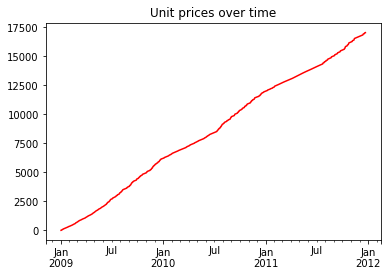

2009-01-02      5.61
2009-01-03     15.61
2009-01-04     21.22
2009-01-05     51.22
2009-01-06     56.83
2009-01-07     80.83
2009-01-08     86.44
2009-01-09     96.44
2009-01-10    120.44
2009-01-11    130.44
Freq: D, dtype: float64

In [5]:
#f = len(data.date_) / (365 * 3)
rng = pd.date_range(start='20090102', end='20111222')
data_nodup = data.drop_duplicates(subset='date_')
ts = pd.Series(data=data_nodup['unit_price'].tolist(),
               index=rng).cumsum()
ts.plot(c='r', title='Unit prices over time')
plt.show()
ts.head(10)

In [6]:
ts.head(10)

2009-01-02      5.61
2009-01-03     15.61
2009-01-04     21.22
2009-01-05     51.22
2009-01-06     56.83
2009-01-07     80.83
2009-01-08     86.44
2009-01-09     96.44
2009-01-10    120.44
2009-01-11    130.44
Freq: D, dtype: float64

In [7]:
TS = np.array(ts)
num_periods = 20
f_horizon = 1

x_data = ts[:(len(TS) - (len(TS) % num_periods))]
x_batches = x_data.values.reshape(-1, 20, 1)

y_data = TS[1:(len(TS) - (len(TS) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 20, 1)

print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:2])
print(y_batches.shape)

54
(54, 20, 1)
[[[  5.61]
  [ 15.61]
  [ 21.22]
  [ 51.22]
  [ 56.83]
  [ 80.83]
  [ 86.44]
  [ 96.44]
  [120.44]
  [130.44]
  [136.05]
  [156.05]
  [166.05]
  [176.05]
  [186.05]
  [196.05]
  [206.05]
  [216.05]
  [226.05]
  [236.05]]

 [[246.05]
  [256.05]
  [266.05]
  [276.05]
  [286.05]
  [296.05]
  [320.05]
  [325.66]
  [335.66]
  [341.27]
  [351.27]
  [361.27]
  [371.27]
  [381.27]
  [386.88]
  [396.88]
  [406.88]
  [416.88]
  [426.88]
  [436.88]]]
[[[ 15.61]
  [ 21.22]
  [ 51.22]
  [ 56.83]
  [ 80.83]
  [ 86.44]
  [ 96.44]
  [120.44]
  [130.44]
  [136.05]
  [156.05]
  [166.05]
  [176.05]
  [186.05]
  [196.05]
  [206.05]
  [216.05]
  [226.05]
  [236.05]
  [246.05]]

 [[256.05]
  [266.05]
  [276.05]
  [286.05]
  [296.05]
  [320.05]
  [325.66]
  [335.66]
  [341.27]
  [351.27]
  [361.27]
  [371.27]
  [381.27]
  [386.88]
  [396.88]
  [406.88]
  [416.88]
  [426.88]
  [436.88]
  [446.88]]]
(54, 20, 1)


In [8]:
# Pull out test data:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX, testY

X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
print(X_test)

(1, 20, 1)
[[[16740.  ]
  [16752.  ]
  [16764.  ]
  [16774.  ]
  [16784.  ]
  [16794.  ]
  [16804.  ]
  [16816.  ]
  [16828.  ]
  [16838.  ]
  [16848.  ]
  [16854.39]
  [16924.39]
  [16930.78]
  [16940.78]
  [16947.17]
  [16959.17]
  [17019.17]
  [17029.17]
  [17039.17]]]


In [9]:
tf.reset_default_graph()

num_periods = 20
inputs = 1
hidden = 100
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

learning_rate = 0.001

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [11]:
#Implement the model on training data
epochs = 1000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches,
                                        y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches,
                                      y: y_batches})
            print(ep, '\tMSE:', mse)
            
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 104473930000.0
100 	MSE: 2819913200.0
200 	MSE: 1005855700.0
300 	MSE: 70645140.0
400 	MSE: 747573.6
500 	MSE: 327306.62
600 	MSE: 287320.5
700 	MSE: 336765.34
800 	MSE: 277286.97
900 	MSE: 294528.62
[[[16758.898]
  [16768.434]
  [16791.99 ]
  [16802.24 ]
  [16811.375]
  [16809.785]
  [16809.475]
  [16820.697]
  [16847.738]
  [16849.275]
  [16857.932]
  [16872.15 ]
  [16915.418]
  [16939.475]
  [16956.55 ]
  [16966.03 ]
  [16980.287]
  [17028.777]
  [17043.477]
  [17067.377]]]


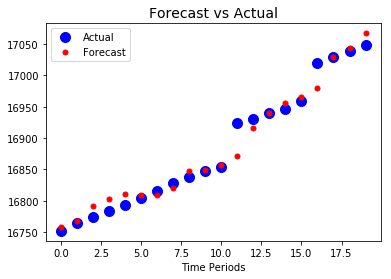

In [13]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()